# Modelo de clasificación de imágenes - Residuos

Fernando Berrocal

## Lectura y preparación de datos

### Conectarse a Drive

In [ ]:
# Conectar con Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importar librerías

In [ ]:
# Importar tensorflow
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# Importar otras librerias requeridas
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score

### Lectura y procesamiento de datos

Las imágenes utilizadas en este proyecto provienen del dataset "Real Waste" disponible en Kaggle (https://www.kaggle.com/datasets/joebeachcapital/realwaste). El dataset fue descargado en formato zip y posteriormente cargado a Google Drive. Dentro de Google Drive, las imágenes se organizaron en una carpeta principal (`images`) y subcarpetas con el nombre de cada clase de residuo, replicando la estructura original del dataset en Kaggle. Finalmente, las imágenes fueron cargadas en este notebook directamente desde dicha carpeta en Google Drive para facilitar la integración con Colab.

In [ ]:
# Ruta a carpeta principal de las imagenes
data_dir = '/content/drive/MyDrive/images'

# Parámetros
img_size = (224, 224)   # Tamaño estándar para red neuronal (puede ser 128x128 o 224x224)
batch_size = 32 # Tamaño de batch

In [ ]:
# Lectura de datos
# Esta funcion lee los datos y:
# - Redimensiona las imagenes
# - Obtiene las etiquetas de cada una, de acuerdo a la carpeta contenedora
# - Codifica los labels de acuerdo a la estrategia indicada
# - Agrupa en batchs
# - Los divide en train y validation
train_ds, val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='both',
    verbose=True,
)

Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Using 950 files for validation.


In [ ]:
# Guardar los labels
class_names = train_ds.class_names
class_names

['cardboard',
 'food_organics',
 'glass',
 'metal',
 'miscellaneous',
 'paper',
 'plastic',
 'textile',
 'vegetation']

In [ ]:
# Ver cuantas imagenes hay en un batch de val_test_ds
for images, labels in val_test_ds.take(1):
    print(images.shape)  # (32, 224, 224, 3)
    print(labels.shape)  # (32,)

(32, 224, 224, 3)
(32,)


In [ ]:
# Ver cuántos batches hay en val_test_ds
val_test_size = tf.data.experimental.cardinality(val_test_ds).numpy()
print(val_test_size)

30


In [ ]:
# Dejar 50% de esos batches para validación, 50% para test
val_size = val_test_size // 2
print(val_size)

15


In [ ]:
val_ds  = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

In [ ]:
# Ver estructura del primer batch de train_ds
for images, labels in train_ds.take(1):
    print(images.shape)  # (32, 224, 224, 3)
    print(labels.shape)  # (32,)

(32, 224, 224, 3)
(32,)


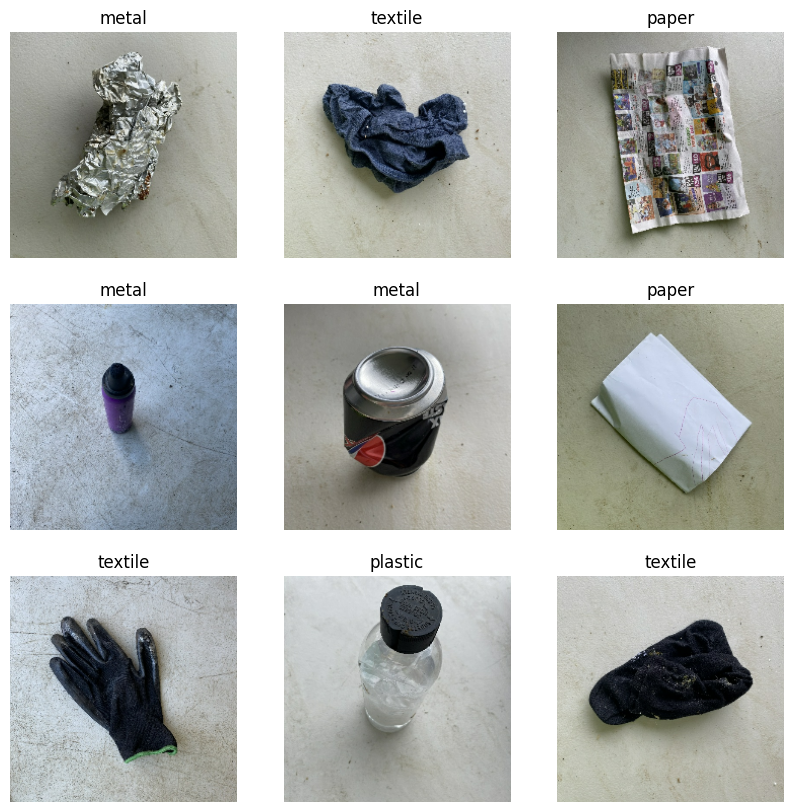

In [ ]:
# Mostrar algunas imagenes de train_ds con su etiqueta
# Tomamos un batch del dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):  # mostramos 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_ds.class_names[labels[i].numpy()])
        plt.axis('off')
    plt.show()

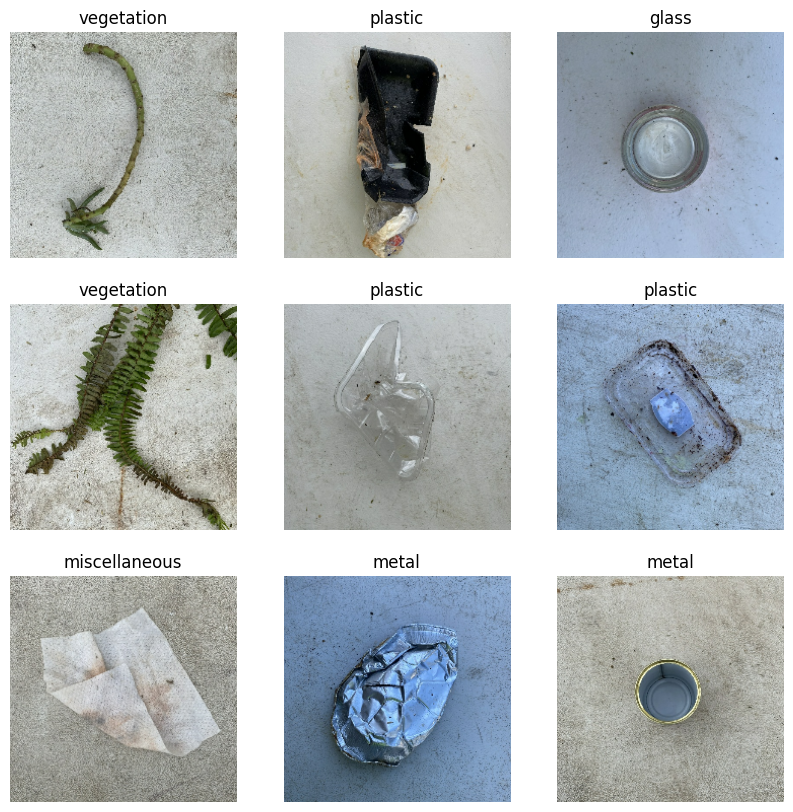

In [ ]:
# Mostrar algunas imagenes de val_ds con su etiqueta
for images, labels in val_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i].numpy()])
        plt.axis('off')
    plt.show()

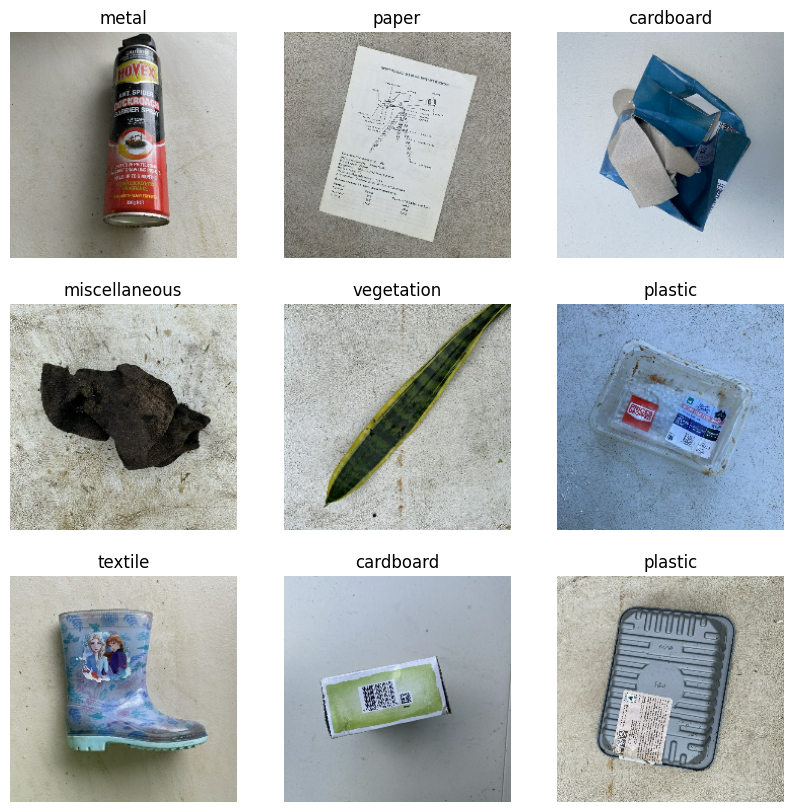

In [ ]:
# Mostrar algunas imagenes de test_ds con su etiqueta
for images, labels in test_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i].numpy()])
        plt.axis('off')
    plt.show()

## Modelo desde cero

### Definición y entrenamiento

In [ ]:
# Definir un modelo CNN

num_classes = len(train_ds.class_names)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Dropout(0.2), # para evitar overfitting

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,377 (1.09 MB)

 Trainable params: 286,377 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',  # porque las etiquetas son int
  metrics=['accuracy']
)

In [ ]:
epochs = 10

In [ ]:
# Entrenar el modelo
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step - accuracy: 0.1619 - loss: 2.1955 - val_accuracy: 0.3042 - val_loss: 2.0391
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.2694 - loss: 1.9508 - val_accuracy: 0.3688 - val_loss: 1.8026
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.3368 - loss: 1.7989 - val_accuracy: 0.4125 - val_loss: 1.6946
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.3665 - loss: 1.7082 - val_accuracy: 0.3958 - val_loss: 1.6426
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 0.3820 - loss: 1.6357 - val_accuracy: 0.4583 - val_loss: 1.5787
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.4202 - loss: 1.5620 - val_accuracy: 0.4542 - val_loss: 1.4380
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.4492 - loss: 1.5174 - val_accuracy: 0.4729 - val_loss: 1.4446
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.4567 - loss: 1.4

### Evaluar el modelo

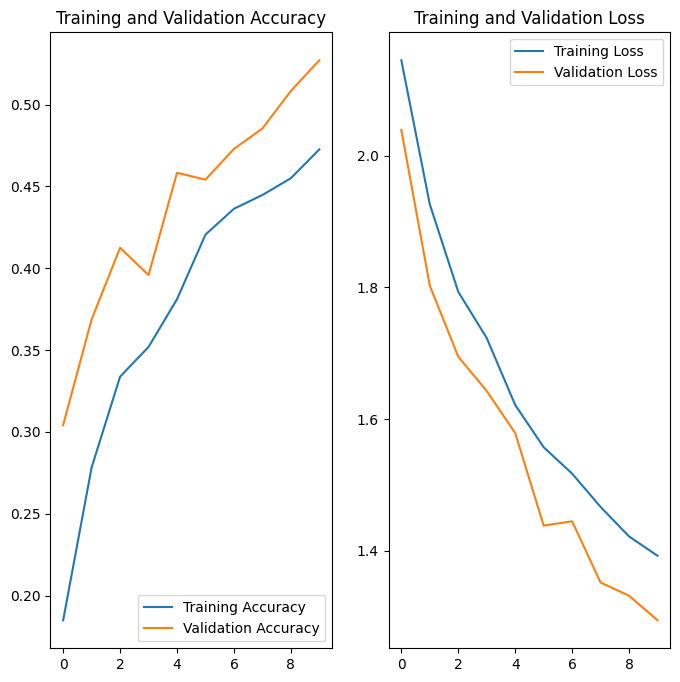

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)             # -> probabilidades (batch, n_classes)
    preds = tf.argmax(preds, axis=1)          # -> clase predicha
    y_true.extend(labels.numpy())             # etiquetas reales
    y_pred.extend(preds.numpy())              # etiquetas predichas

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


In [ ]:
# F1 por clase y macro
print('F1-score por clase:', f1_score(y_true, y_pred, average=None))
print('F1-score macro:', f1_score(y_true, y_pred, average='macro'))

F1-score por clase: [0.41463415 0.5        0.59701493 0.46590909 0.23188406 0.4957265
 0.44954128 0.32653061 0.79245283]
F1-score macro: 0.47485482701760506


In [ ]:
# Reporte detallado
print(classification_report(y_true, y_pred, target_names=class_names))

               precision    recall  f1-score   support

    cardboard       0.46      0.38      0.41        45
food_organics       0.64      0.41      0.50        34
        glass       0.67      0.54      0.60        37
        metal       0.41      0.54      0.47        76
miscellaneous       0.42      0.16      0.23        50
        paper       0.44      0.57      0.50        51
      plastic       0.40      0.51      0.45        97
      textile       0.67      0.22      0.33        37
   vegetation       0.67      0.98      0.79        43

     accuracy                           0.49       470
    macro avg       0.53      0.48      0.47       470
 weighted avg       0.50      0.49      0.47       470



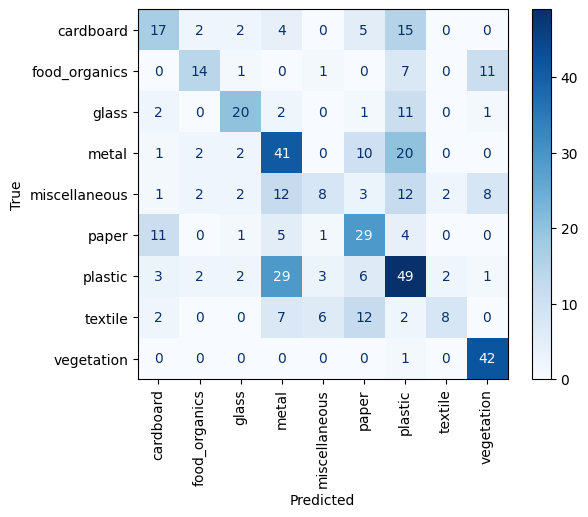

In [ ]:
# Matriz de confusion
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, values_format='d', cmap='Blues', display_labels=class_names)
plt.xticks(rotation=90)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Transfer Learning

### Obtener el modelo pre-entrenado

In [ ]:
# Importar modelo Resnet50V2
from tensorflow.keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input

### Definición y entrenamiento

In [ ]:
base_model = ResNet50V2(
    weights='imagenet',  # Cargar pesos pre-entrenados en ImageNet
    input_shape=(224, 224, 3),
    include_top=False, # No incluir el clasificador de ImageNet en el top del modelo
)

# Congelar el modelo base (todas las capas)
# Para no modificarlas
base_model.trainable = False

# Crear un bloque de clasificacion nuevo en el top / salida del modelo
inputs = tf.keras.layers.Input(shape=(224, 224, 3))

# Los pesos pre-entrenados de ResNet50V2 requieren que los datos de entrada
# esten escalados de (0, 255) a un rango de (-1., +1.)
# scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = preprocess_input(inputs)
# scale_layer = tf.keras.layers.Lambda(preprocess_input) # Add preprocess_input as a Lambda layer
# x = scale_layer(inputs)

# Agregar el clasificador al modelo base
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularizacion
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_pretrain = tf.keras.Model(inputs, outputs)

model_pretrain.summary(show_trainable=True)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50v2 (Functional)     │ (None, 7, 7, 2048)    │ 23,564,800 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 100352)        │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 64)            │  6,422,592 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 9)             │        585 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 29,987,977 (114.40 MB)

 Trainable params: 6,423,177 (24.50 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# --- Fase 1 de Entrenamiento ---
# Compilamos y entrenamos solo el nuevo clasificador
model_pretrain.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',  # porque las etiquetas son int
  metrics=['accuracy']
)

In [ ]:
# --- Entrenando solo el clasificador nuevo ('head/top') ---
history_pretrain = model_pretrain.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.3273 - loss: 4.9246 - val_accuracy: 0.3542 - val_loss: 1.5899
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.4233 - loss: 1.5987 - val_accuracy: 0.5000 - val_loss: 1.4301
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.4931 - loss: 1.3785 - val_accuracy: 0.5292 - val_loss: 1.4704
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.5498 - loss: 1.2498 - val_accuracy: 0.6229 - val_loss: 1.3196
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.5709 - loss: 1.1240 - val_accuracy: 0.5917 - val_loss: 1.3027
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 0.6065 - loss: 1.1149 - val_accuracy: 0.5938 - val_loss: 1.2139
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.6058 - loss: 1.0177 - val_accuracy: 0.6646 - val_loss: 1.1122
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.6434 - loss: 0

In [ ]:
# --- Descongelar las últimas capas de la base ---
# Hacemos toda la base "entrenable"
base_model.trainable = True

# Pero congelamos de nuevo todas las capas excepto las últimas 4
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [ ]:
# --- Fase 2 de Entrenamiento (con learning rate bajo) ---
# Re-compilamos el modelo con un optimizador de learning rate muy bajo
# para no destruir las características pre-entrenadas.
model_pretrain.compile(
  optimizer=tf.keras.optimizers.Adam(1e-5),  # Bajo learning rate
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [ ]:
# Se puede saber cual fue la última época de entrenamiento realizada al modelo
print(history_pretrain.epoch)
print(history_pretrain.epoch[-1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
9


In [ ]:
# Continuamos el entrenamiento desde donde lo dejamos
# Ya se ha entrenado em modelo (pesos pre-entrenados y clasificador nuevo),
# se continuará el entrenamiento por 10 épocas más (hasta alcanzar 20),
# para que además se entrenen las últimas 4 capas con nuestros datos (fine-tuning),
# el resto de capas permanecen con los pesos originales de ImageNet
history_fine_tune = model_pretrain.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20, # Debe ser mayor al número de épocas utilizado anteriormente
  initial_epoch=history_pretrain.epoch[-1]
)

Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 232ms/step - accuracy: 0.7243 - loss: 0.7832 - val_accuracy: 0.7083 - val_loss: 1.2258
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.7325 - loss: 0.7314 - val_accuracy: 0.7083 - val_loss: 1.2222
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.7352 - loss: 0.7029 - val_accuracy: 0.7083 - val_loss: 1.2318
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.7395 - loss: 0.6774 - val_accuracy: 0.7125 - val_loss: 1.2379
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.7556 - loss: 0.6370 - val_accuracy: 0.7125 - val_loss: 1.2411
Epoch 15/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.7573 - loss: 0.6283 - val_accuracy: 0.7229 - val_loss: 1.2504
Epoch 16/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.7580 - loss: 0.6406 - val_accuracy: 0.7229 - val_loss: 1.2576
Epoch 17/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.7581 -

### Evaluar el modelo

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_pretrain.predict(images)    # -> probabilidades (batch, n_classes)
    preds = tf.argmax(preds, axis=1)          # -> clase predicha
    y_true.extend(labels.numpy())             # etiquetas reales
    y_pred.extend(preds.numpy())              # etiquetas predichas

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [ ]:
# F1 por clase y macro
print('F1-score por clase:', f1_score(y_true, y_pred, average=None))
print('F1-score macro:', f1_score(y_true, y_pred, average='macro'))

F1-score por clase: [0.65934066 0.77777778 0.68656716 0.75949367 0.3956044  0.75
 0.77294686 0.73239437 0.94252874]
F1-score macro: 0.7196281810578624


In [ ]:
# Reporte detallado
print(classification_report(y_true, y_pred, target_names=class_names))

               precision    recall  f1-score   support

    cardboard       0.65      0.67      0.66        45
food_organics       0.74      0.82      0.78        34
        glass       0.77      0.62      0.69        37
        metal       0.73      0.79      0.76        76
miscellaneous       0.44      0.36      0.40        50
        paper       0.80      0.71      0.75        51
      plastic       0.73      0.82      0.77        97
      textile       0.76      0.70      0.73        37
   vegetation       0.93      0.95      0.94        43

     accuracy                           0.73       470
    macro avg       0.73      0.72      0.72       470
 weighted avg       0.72      0.73      0.72       470



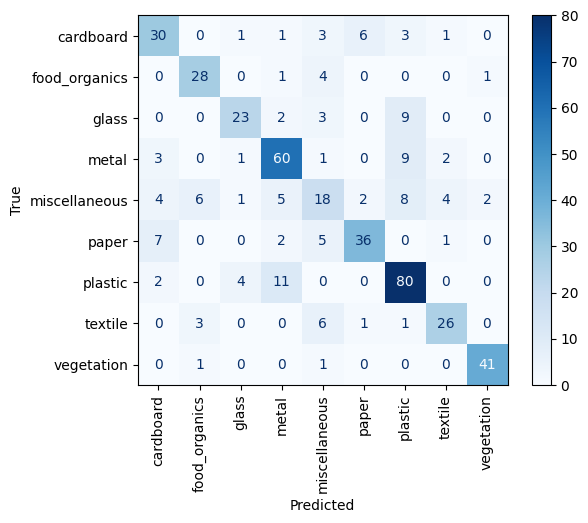

In [ ]:
# Matriz de confusion
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, values_format='d', cmap='Blues', display_labels=class_names)
plt.xticks(rotation=90)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


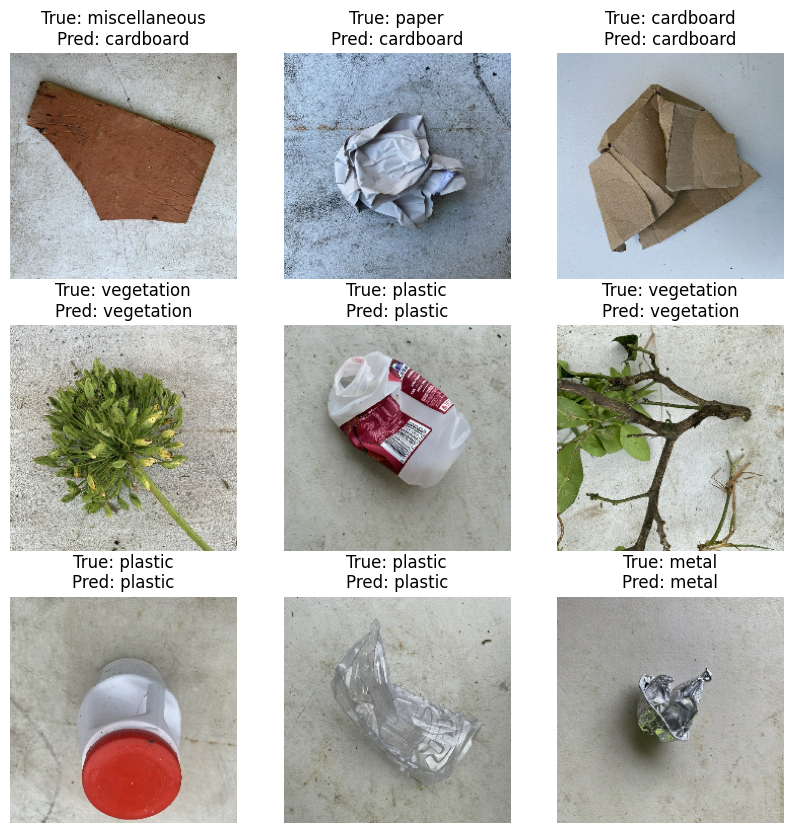

In [ ]:
# Mostrar algunas predicciones del test_ds, tomando un batch aleatorio

# Para seleccionar un batch diferente, se puede usar el método .skip() antes de .take(1).
# Esto omitirá el número especificado de batches y luego tomará el siguiente

batch_to_skip = 5 # Cambiar este numero para seleccionar un batch diferente

# Se muestran algunas predicciones del batch batch_to_display + 1 = 6
# del test_ds
for images, labels in test_ds.skip(batch_to_skip).take(1):
    preds = model_pretrain.predict(images)
    preds = tf.argmax(preds, axis=1)
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}')
        plt.axis('off')
    plt.show()

## Análisis Comparativo de Modelos

Se han entrenado dos modelos para la clasificación de imágenes de diferentes tipos de residuos:

1.  **Modelo desde cero (CNN):** Una red neuronal convolucional construida y entrenada desde cero con los datos proporcionados.
2.  **Modelo con Transfer Learning (ResNet50V2 + Clasificador):** Se utilizó un modelo pre-entrenado en ImageNet (ResNet50V2) y se añadió un clasificador en la parte superior, entrenando primero solo el clasificador y luego realizando un ajuste fino (fine-tuning) de las últimas 4 capas de la base pre-entrenada.

A continuación, se presenta un análisis comparativo basado en las métricas de evaluación obtenidas en el conjunto de prueba:

### Comparación General de Métricas

| Modelo                  | Accuracy | F1-score Macro |
| :---------------------- | :------- | :------------- |
| Modelo desde cero (CNN) | 0.49     | 0.47           |
| Transfer Learning       | 0.73     | 0.72           |

Como se puede observar, el modelo que utiliza Transfer Learning con ResNet50V2 obtuvo métricas de rendimiento significativamente superiores en el conjunto de prueba en comparación con el modelo entrenado desde cero. Esto es un resultado esperado, ya que el modelo pre-entrenado ha aprendido características visuales complejas de un conjunto de datos muy grande (ImageNet), lo que le permite tener una mejor capacidad de generalización para la nueva tarea de clasificación de residuos.

### Clases con Mejor Desempeño

Para identificar las clases donde los modelos tienen un mejor rendimiento, analizamos los F1-scores por clase:

**Modelo desde cero (CNN):**

Las clases con los F1-scores más altos son:

*   `vegetation`: 0.79
*   `glass`: 0.60
*   `food_organics`: 0.50
*   `paper`: 0.50

**Modelo con Transfer Learning:**

Las clases con los F1-scores más altos son:

*   `vegetation`: 0.94
*   `food_organics`: 0.78
*   `plastic`: 0.77
*   `metal`: 0.76

En ambos modelos, la clase `vegetation` parece ser la más fácil de clasificar, probablemente debido a características visuales más distintivas y menos variabilidad dentro de la clase. El modelo con Transfer Learning muestra un rendimiento notablemente mejor en casi todas las clases.

### Clases con Menor Desempeño

Para identificar las clases donde los modelos tienen más dificultades, analizamos los F1-scores por clase y las matrices de confusión:

**Modelo desde cero (CNN):**

Las clases con los F1-scores más bajos son:

*   `miscellaneous`: 0.23
*   `textile`: 0.33
*   `cardboard`: 0.41
*   `metal`: 0.47

La matriz de confusión para este modelo muestra que hay una dispersión considerable en las predicciones. Por ejemplo:

*   `miscellaneous` se confunde frecuentemente con `metal`, `paper`, `plastic` y `textile`.
*   `cardboard` se confunde a menudo con `paper` y `plastic`.
*   `plastic` tiene un número significativo de predicciones incorrectas hacia `metal`, `miscellaneous`, `paper` y `textile`.

**Modelo con Transfer Learning:**

Aunque el rendimiento general es mucho mejor, las clases con F1-scores relativamente más bajos son:

*   `miscellaneous`: 0.40
*   `cardboard`: 0.66
*   `glass`: 0.69
*   `textile`: 0.73

La matriz de confusión para este modelo muestra que las confusiones son menores, pero aún existen:

*   `miscellaneous` sigue siendo una clase problemática, confundiéndose con `metal`, `paper`, `plastic` y `textile`.
*   `cardboard` se confunde con `paper` y `plastic`.

En ambos modelos, la clase `miscellaneous` parece ser la más difícil de clasificar, probablemente debido a la heterogeneidad de los objetos que pertenecen a esta categoría.

### Recomendaciones de Mejora

Dado que el modelo con Transfer Learning ha demostrado un rendimiento superior, las recomendaciones de mejora podrian centrarse principalmente en:

1.  **Aumento de Datos (Data Augmentation):** Implementar técnicas de aumento de datos en tiempo real durante el entrenamiento (rotaciones, zooms, cambios de brillo, etc.) puede ayudar a aumentar la cantidad de datos de entrenamiento y mejorar la robustez del modelo, especialmente para las clases con menos ejemplos o mayor variabilidad.
2.  **Ajuste Fino Adicional:** Experimentar con el ajuste fino de más capas en la base pre-entrenada. Se podría intentar descongelar más capas de `base_model` y entrenarlas con un learning rate muy bajo. Es crucial monitorear las curvas de entrenamiento y validación para evitar el sobreajuste.
3.  **Optimización de Hiperparámetros:** Ajustar el learning rate del optimizador (especialmente en la fase de ajuste fino), el número de épocas para cada fase de entrenamiento y los parámetros de las capas densas y dropout.
4.  **Capas Adicionales en el Clasificador:** Probar diferentes arquitecturas para el clasificador superior, añadiendo más capas densas o modificando el número de neuronas, siempre teniendo cuidado de no añadir demasiada complejidad que pueda llevar a sobreajuste.
5.  **Considerar Otros Modelos Pre-entrenados:** Experimentar con otros modelos pre-entrenados populares para clasificación de imágenes como VGG16, InceptionV3, EfficientNet, etc., para ver si alguno se adapta mejor a las características de este conjunto de datos.
6.  **Manejo de Clases Desbalanceadas:** Si hay un desbalance significativo en el número de imágenes por clase (aunque en este caso no parece ser extremo según el soporte en el reporte de clasificación), se podrían aplicar técnicas como el sobremuestreo de clases minoritarias o el submuestreo de clases mayoritarias, o utilizar funciones de pérdida que manejen el desbalance.
7.  **Análisis de Errores Específicos:** Examinar visualmente las imágenes que fueron clasificadas incorrectamente, especialmente para las clases problemáticas como `miscellaneous`, para entender mejor las razones de los errores y si hay patrones que puedan abordarse (por ejemplo, imágenes de baja calidad, objetos poco representativos de la clase, etc.).

### Aplicabilidad

El modelo con Transfer Learning, con un accuracy del 73% y un F1-score macro del 72%, muestra un rendimiento prometedor para la tarea de clasificación de residuos. Si bien no es perfecto, ya podría ser aplicable en escenarios donde se necesite una clasificación inicial o como parte de un sistema más complejo.

La aplicabilidad dependerá de los requisitos específicos del caso de uso:

*   **Prototipos y Demostraciones:** El modelo actual es definitivamente útil para prototipos y demostraciones de un sistema de clasificación de residuos.
*   **Sistemas de Soporte a la Clasificación Manual:** Podría usarse para pre-clasificar imágenes y reducir la carga de trabajo manual, donde un humano revisaría y corregiría las predicciones del modelo.
*   **Aplicaciones con Tolerancia a Errores:** En aplicaciones donde un cierto nivel de error es aceptable (por ejemplo, para obtener estadísticas generales sobre la composición de los residuos), el modelo podría ser directamente aplicable.
*   **Sistemas de Clasificación Automatizada (requiere mayor precisión):** Para sistemas completamente automatizados donde se requiere una alta precisión (por ejemplo, para operar maquinaria de clasificación), el rendimiento actual podría no ser suficiente y se necesitarían las mejoras mencionadas anteriormente para reducir la tasa de error, especialmente en las clases con menor rendimiento.

En resumen, el enfoque de Transfer Learning fue significativamente más efectivo que entrenar un modelo desde cero para este conjunto de datos. El modelo resultante es aplicable en varios contextos, pero para aplicaciones que exijan alta precisión, se recomienda implementar las mejoras sugeridas.